# Pb from BC parameterization

Using only Alert, Nunavut observations (Sharma et al., 2019). https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019JD030844

General source: World Database for Aerosols (https://www.gaw-wdca.org/). "As a general reference to the monitoring efforts and data contained in EBAS we suggest the paper http://www.atmos-chem-phys.net/12/5447/2012/acp-12-5447-2012.pdf "

#### Pb data
    - data type: arithmetic mean 
    - instrument type: high_vol_sampler (CA01L_HVS420_HM_MC) (https://amt.copernicus.org/preprints/amt-2016-12/amt-2016-12.pdf)
    - frequency: 1w
    - dates available: 1980-07-19 to 1995-05-22
    
#### Equivalent Black Carbon (EBC) data
    - data type: arithmetic mean, wavelength 820 
    - instrument type: filter_absorption_photometer (CA05L_Magee_Model_AE6) (https://psl.noaa.gov/iasoa/node/81) --> if anything, potentially biased high
    - frequency: 1h
    - dates available: 1989-05-29 to 1992-12-31, 2011-01-01 to 2012-12-29
    --> monthly averages 2011-03 to 2013-12 in supplement (https://acp.copernicus.org/articles/17/15225/2017/acp-17-15225-2017-supplement.pdf)
    - more data should be available... https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2003JD004331, https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2005JD006581

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import numpy
import pandas as pd
import datetime
from matplotlib.dates import date2num, num2date
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap, cm
import calendar
import seaborn as sns
from scipy.optimize import leastsq
from scipy.stats import pearsonr, spearmanr
import xarray as xr
import netCDF4 as nc
from scipy.signal import butter,filtfilt

%matplotlib inline

#### Parameters:

In [31]:
# Colors:
color_Pb = '#625b62'
color_BC = '#b2b2b2'

# domain dimensions:
imin, imax = 1100, 2180
jmin, jmax = 160, 800

mesh         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20210729.nc')
mesh_lon     = np.array(mesh.variables['nav_lon'])
mesh_lat     = np.array(mesh.variables['nav_lat'])
mesh_bathy   = np.array(mesh.variables['tmask'][0,:,:,:])
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = np.array(mesh.variables['nav_lev'])

#### Load data

In [38]:
Alert     = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/Alert_1989-1992.nc')
Alert_EBC = Alert['EBC'].values*1e3 # ng/m3
Alert_EBC_dates = num2date(Alert['EBC_dates'].values)
Alert_Pb        = Alert['Pb'].values
Alert_Pb_dates  = num2date(Alert['Pb_dates'].values)

#### Functions

In [32]:
def toTimestamp(d):
    return calendar.timegm(d.timetuple())

In [33]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
    """

    if x.ndim != 1:
        raise ValueError#, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError#, "Input vector needs to be bigger than window size."

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError#, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [34]:
def lin_fit(x, y):
    '''Fits a linear fit of the form mx+b to the data'''
    fitfunc = lambda params, x: params[0] * x  
    errfunc = lambda p, x, y: fitfunc(p, x) - y              #create error function for least squares fit

    init_a = 0.5                            #find initial value for a (gradient)
    init_p = np.array((init_a))  #bundle initial values in initial parameters

    #calculate best fitting parameters (i.e. ) using the error function
    p1, success = leastsq(errfunc, init_p.copy(), args = (x, y))
    f = fitfunc(p1, x)          #create a fit with those parameters
    return p1, f  

In [35]:
def boxcar_filter_data(variable, sample_frequency='7d', window_len='5d', window='flat'):
    # Calculate boxcar window length based on 
    
    if (window_len[-1] == 'd'):
        if (sample_frequency[-1] == 'd'): # units of days
            window_length = int(window_len[:-1]) / int(sample_frequency[:-1])
        elif (sample_frequency[-1] == 'h'): # units of hours
            window_length = int(window_len[:-1])*24 / int(sample_frequency[:-1])            
        else:
            prin('Sampling_frequency can only be in units of h (hours) or d (days)')
    else:
        print('Boxcar window_len can only be in units of d (days)')
    
    boxcar = smooth(variable, window_len=int(window_length), window=window)

    ind = int(np.floor(window_length/2))
    
    return boxcar[ind:-ind+1]

In [36]:
def butter_lowpassfilter_data(variable, dates, days_filter=7):
    
    # Timestep size
    dt_variable = (dates[1]-dates[0]).total_seconds()
    
    # Butterworth filter: 
#     variable_cutoff         = (1/(dt_variable*days_filter))/(1/dt_variable) # filter frequency / sampling frequency
    variable_cutoff         = (1/(3600*24*days_filter))/(1/dt_variable) # filter frequency / sampling frequency
    variable_b, variable_a  = butter(3, variable_cutoff, btype='low', analog=False) # (order of function, cutoff)
    variable_filtered       = filtfilt(variable_b, variable_a, variable)
    
    return variable_filtered

In [37]:
def fourier_filter_data(variable, dates, days_filter=1):
    # Timestep size
    dt_var = (dates[1]-dates[0]).total_seconds()
    
    # Fourier transform:
    amp_var   = np.fft.rfft(variable)
    freqs_var = np.fft.rfftfreq(variable.size, dt_var)
    phase_var = np.arctan2(amp_var.imag, amp_var.real)
    
    # Apply low bandpass filter:
    filter_var = amp_var.copy()
    filter_var[(freqs_var > 1/(days_filter*24*3600))] = 0
    var_filtered = np.fft.irfft(filter_var)
    
    return var_filtered

In [51]:
def resample_data(dates, variable, time_step='7d'):
    datetime_dates = [pd.to_datetime(date) for date in dates]
        
    # resample / interpolate data before applying filters so that they are evenly spaced to time_step size in days    
    if time_step[-1] == 'd':
        # units of days
        n_steps       = np.floor((datetime_dates[-1] - datetime_dates[0]).days / float(time_step[:-1])) # Number of time steps to apply
        gridded_dates = np.array([datetime_dates[0] + datetime.timedelta(days=int(time_step[:-1])*n) for n in range(int(n_steps))])
    elif time_step[-1] == 'h':
        # units of hours
        n_steps       = np.floor((datetime_dates[-1] - datetime_dates[0]).days*24 / float(time_step[:-1])) # Number of time steps to apply
        gridded_dates = np.array([datetime_dates[0] + datetime.timedelta(hours=int(time_step[:-1])*n) for n in range(int(n_steps))])
    else:
        print("Function is only set up for time_step units in d (days) or h (hour)")

    # convert dates to timestamps for interpolation
    timestamp_dates         = np.array([toTimestamp(t) for t in datetime_dates])
    timestamp_gridded_dates = np.array([toTimestamp(t) for t in gridded_dates])
    
    # interpolate dates:
    variable_gridded = np.interp(timestamp_gridded_dates, timestamp_dates, variable)

    return gridded_dates, variable_gridded

#### Figures

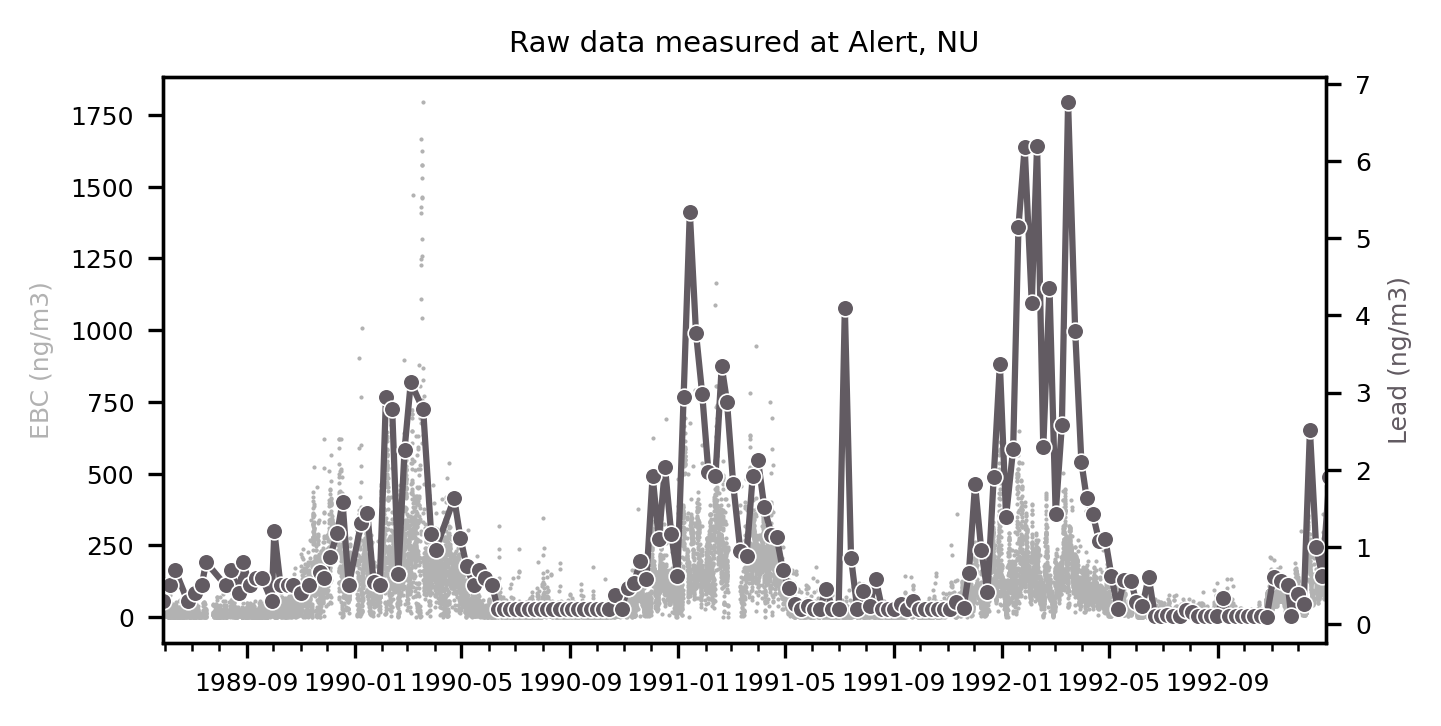

In [39]:
fig, ax = plt.subplots(1,1, figsize=(5, 2.5), dpi=300)

# Alert data ------------------
ax.plot_date(Alert_EBC_dates, Alert_EBC,'.', color=color_BC, markersize=1, markeredgewidth=0.5)
ax.set_xlim([Alert_EBC_dates[0], Alert_EBC_dates[-1]])
ax.set_ylabel('EBC (ng/m3)', fontsize=6, color=color_BC)
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.set_title('Raw data measured at Alert, NU', fontsize=7)

ax1 = ax.twinx()
ax1.plot_date(Alert_Pb_dates, Alert_Pb,'.-', color=color_Pb, markersize=8, markeredgecolor='w', markeredgewidth=0.4)
ax1.set_ylabel('Lead (ng/m3)', fontsize=6, color=color_Pb)
ax1.set_xlim([Alert_EBC_dates[0], Alert_EBC_dates[-1]])

ax.tick_params(axis='both', which='major', labelsize=6)
ax1.tick_params(axis='both', which='major', labelsize=6)

Match nearest dates of measurements:

In [62]:
Alert_indx_BC = np.array([])
Alert_indx_Pb = np.array([])

# Create arrays of the time periods when there are Pb and EBC data:
for ind, Pb_date in enumerate(Alert_Pb_dates):
    if ind > 17: # overlapping time period
        # Find index of nearest BC date for each Pb measurement:
        difference = np.array([(Pb_date - EBC_date).total_seconds() for EBC_date in Alert_EBC_dates])
        indx_add = np.argmin(np.abs(difference))
        Alert_indx_BC  = np.append(Alert_indx_BC, int(indx_add))
        # And save index of Pb element too:
        Alert_indx_Pb  = np.append(Alert_indx_Pb, int(ind))
        
Alert_Pb_dates_match  = np.array([Alert_Pb_dates[int(ix)] for ix in Alert_indx_Pb])
Alert_Pb_match        = np.array([Alert_Pb[int(ix)] for ix in Alert_indx_Pb])
Alert_EBC_dates_match = np.array([Alert_EBC_dates[int(ix)] for ix in Alert_indx_BC])
Alert_EBC_match       = np.array([Alert_EBC[int(ix)] for ix in Alert_indx_BC])

In [41]:
print(Alert_Pb_dates_match.shape, Alert_Pb_match.shape, Alert_EBC_dates_match.shape, Alert_EBC_match.shape)

(181,) (181,) (181,) (181,)


Subset to correct date range:

In [44]:
Alert_Pb_dates_subset  = Alert_Pb_dates[18:]
Alert_Pb_subset        = Alert_Pb[18:]
Alert_EBC_dates_subset = Alert_EBC_dates[:]
Alert_EBC_subset       = Alert_EBC[:]

Process / filter data:

In [52]:
# Grids are irregular, so interpolate to regular grid:
Alert_Pb_dates_gridded , Alert_Pb_gridded  = resample_data(Alert_Pb_dates_subset, Alert_Pb_subset, time_step='7d')   # Measured roughly weekly
Alert_EBC_dates_gridded, Alert_EBC_gridded = resample_data(Alert_EBC_dates_subset, Alert_EBC_subset, time_step='1h') # Measured roughly hourly

In [53]:
Alert_Pb_boxcar  = boxcar_filter_data(Alert_Pb_gridded , sample_frequency='7d', window_len='30d')
Alert_EBC_boxcar = boxcar_filter_data(Alert_EBC_gridded, sample_frequency='1h', window_len='30d')

In [54]:
Alert_Pb_butter  = butter_lowpassfilter_data(Alert_Pb_gridded, Alert_Pb_dates_gridded, days_filter=30)
Alert_EBC_butter = butter_lowpassfilter_data(Alert_EBC_gridded, Alert_EBC_dates_gridded, days_filter=30)

In [55]:
Alert_Pb_fourier  = fourier_filter_data(Alert_Pb_gridded, Alert_Pb_dates_gridded, days_filter=30)
Alert_EBC_fourier = fourier_filter_data(Alert_EBC_gridded, Alert_EBC_dates_gridded, days_filter=30)

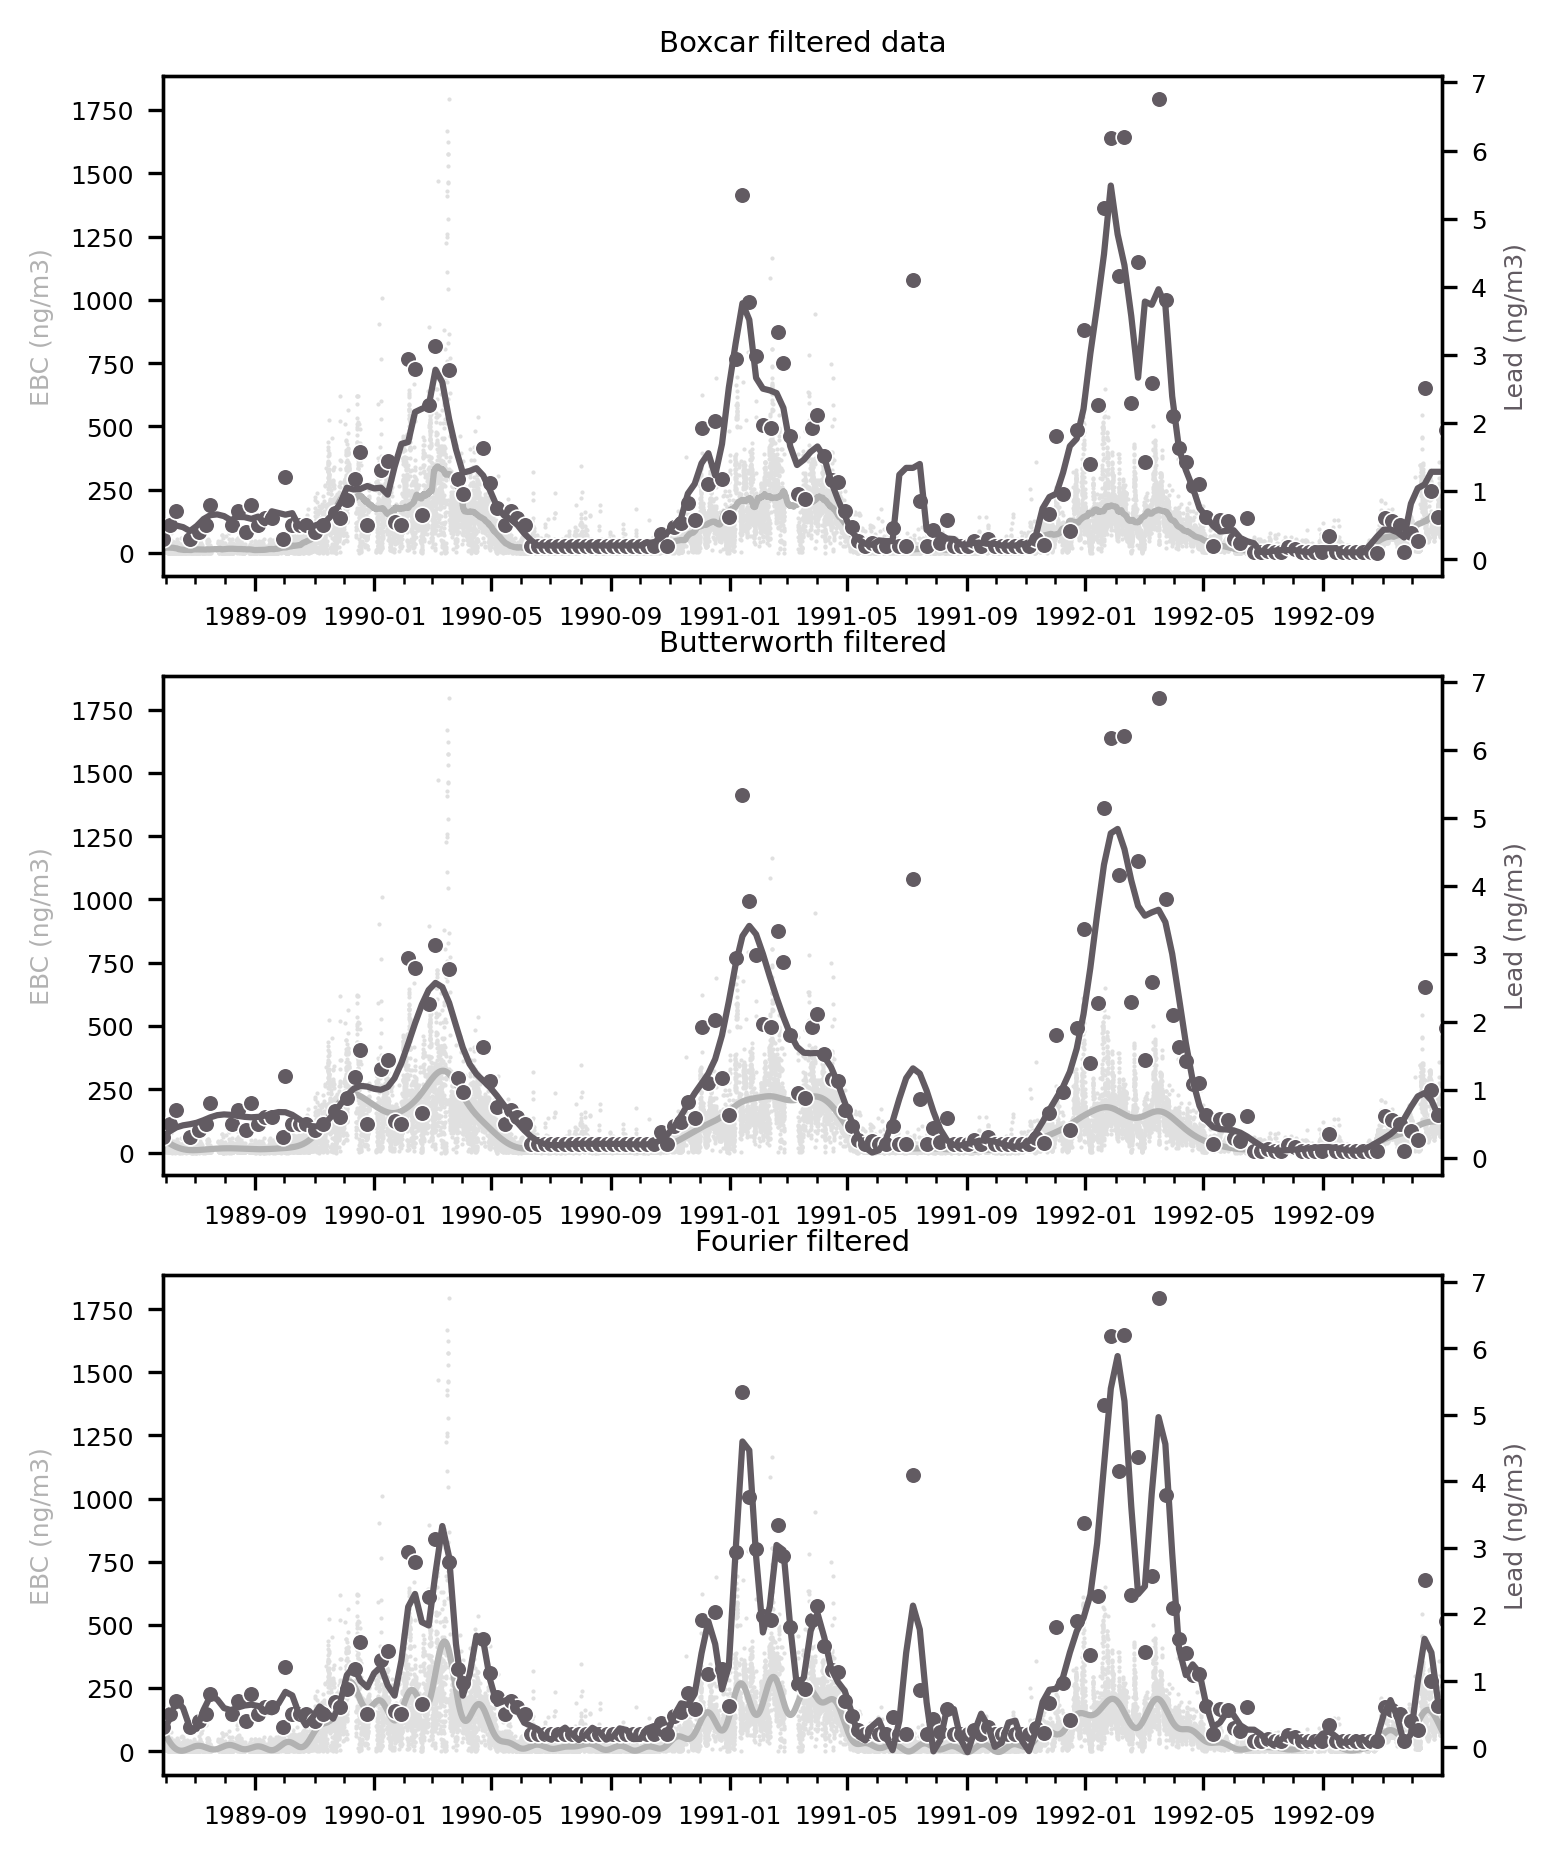

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(5.5, 7.5), dpi=300)

for axis in ax.ravel():
    axis.tick_params(axis='both', which='major', labelsize=6)
    axis.set_ylabel('EBC (ng/m3)', fontsize=6, color=color_BC)
    axis.xaxis.set_minor_locator(mdates.MonthLocator())
    axis.set_xlim([Alert_EBC_dates[0], Alert_EBC_dates[-1]])
    
# Boxcar filter --------------------------
ax[0].set_title('Boxcar filtered data', fontsize=7)
ax[0].plot_date(Alert_EBC_dates, Alert_EBC,'.', color='#e0e0e0', markersize=1, markeredgewidth=0.5)
ax[0].plot_date(Alert_EBC_dates_gridded, Alert_EBC_boxcar,'-', color=color_BC)
ax1 = ax[0].twinx()
ax1.plot_date(Alert_Pb_dates, Alert_Pb,'.', color=color_Pb, markersize=8, markeredgecolor='w', markeredgewidth=0.4)
ax1.plot_date(Alert_Pb_dates_gridded, Alert_Pb_boxcar,'-', color=color_Pb)

# Butterworth filter -----------------------------
ax[1].set_title('Butterworth filtered', fontsize=7)
ax[1].plot_date(Alert_EBC_dates, Alert_EBC,'.', color='#e0e0e0', markersize=1, markeredgewidth=0.5)
ax[1].plot_date(Alert_EBC_dates_gridded, Alert_EBC_butter,'-', color=color_BC)
ax2 = ax[1].twinx()
ax2.plot_date(Alert_Pb_dates, Alert_Pb,'.', color=color_Pb, markersize=8, markeredgecolor='w', markeredgewidth=0.4)
ax2.plot_date(Alert_Pb_dates_gridded, Alert_Pb_butter,'-', color=color_Pb)

# Fourier filtered -------------------------------
ax[2].set_title('Fourier filtered', fontsize=7)
ax[2].plot_date(Alert_EBC_dates, Alert_EBC,'.', color='#e0e0e0', markersize=1, markeredgewidth=0.5)
ax[2].plot_date(Alert_EBC_dates_gridded, Alert_EBC_fourier,'-', color=color_BC)
ax3 = ax[2].twinx()
ax3.plot_date(Alert_Pb_dates, Alert_Pb,'.', color=color_Pb, markersize=8, markeredgecolor='w', markeredgewidth=0.4)
ax3.plot_date(Alert_Pb_dates_gridded, Alert_Pb_fourier,'-', color=color_Pb)

for axis in [ax1, ax2, ax3]:
    axis.tick_params(axis='both', which='major', labelsize=6)
    axis.set_ylabel('Lead (ng/m3)', fontsize=6, color=color_Pb)
    axis.xaxis.set_minor_locator(mdates.MonthLocator())
    axis.set_xlim([Alert_EBC_dates[0], Alert_EBC_dates[-1]])

#### Correlate Pb:BC

First, match the dates again:

In [60]:
def match_dates(array1, array2, array1_dates, array2_dates):
    indx_array1 = np.array([])
    indx_array2 = np.array([])

    # Create arrays of the time periods when there are Pb and EBC data:
    for ind, date1 in enumerate(array1_dates):
        # Find index of nearest date for each measurement:
        difference = np.array([(date1 - date2).total_seconds() for date2 in array2_dates])
        indx_add = np.argmin(np.abs(difference))
        # Save indices to array:
        indx_array1  = np.append(indx_array1, int(ind))
        indx_array2  = np.append(indx_array2, int(indx_add))
        
    array1_dates_match = np.array([array1_dates[int(ix)] for ix in indx_array1])
    array1_match       = np.array([array1[int(ix)] for ix in indx_array1])
    array2_dates_match = np.array([array2_dates[int(ix)] for ix in indx_array2])
    array2_match       = np.array([array2[int(ix)] for ix in indx_array2])

    return array1_match, array2_match, array1_dates_match, array2_dates_match

In [63]:
# No Filtering
# Linear fit:
p1_start_Alert, f_start_Alert = lin_fit(Alert_EBC_match, Alert_Pb_match)
print(p1_start_Alert, 1/p1_start_Alert) # Pb = ratio*BC

[0.00787857] [126.92659615]


In [65]:
# Boxcar:
Alert_Pb_boxcar_match, Alert_EBC_boxcar_match, \
    Alert_Pb_dates_boxcar_match, Alert_EBC_dates_boxcar_match = match_dates(Alert_Pb_boxcar, Alert_EBC_boxcar, \
                                                                           Alert_Pb_dates_gridded, Alert_EBC_dates_gridded)

# Linear fit:
p1_boxcar_Alert, f_boxcar_Alert = lin_fit(Alert_EBC_boxcar_match, Alert_Pb_boxcar_match)
print(p1_boxcar_Alert, 1/p1_boxcar_Alert) # Pb = ratio*BC

[0.01099602] [90.94195992]


In [66]:
# Butterworth:
Alert_Pb_butter_match, Alert_EBC_butter_match, \
    Alert_Pb_dates_butter_match, Alert_EBC_dates_butter_match = match_dates(Alert_Pb_butter, Alert_EBC_butter, \
                                                                           Alert_Pb_dates_gridded, Alert_EBC_dates_gridded)

# Linear fit:
p1_butter_Alert, f_butter_Alert = lin_fit(Alert_EBC_butter_match, Alert_Pb_butter_match)
print(p1_butter_Alert, 1/p1_butter_Alert) # Pb = ratio*BC

[0.01091973] [91.57738215]


In [67]:
# Fourier filtered:
Alert_Pb_fourier_match, Alert_EBC_fourier_match, \
    Alert_Pb_dates_fourier_match, Alert_EBC_dates_fourier_match = match_dates(Alert_Pb_fourier, Alert_EBC_fourier, \
                                                                           Alert_Pb_dates_gridded, Alert_EBC_dates_gridded)

p1_fourier_Alert, f_fourier_Alert = lin_fit(Alert_EBC_fourier_match, Alert_Pb_fourier_match)
print(p1_fourier_Alert, 1/p1_fourier_Alert)

[0.01084316] [92.22404741]


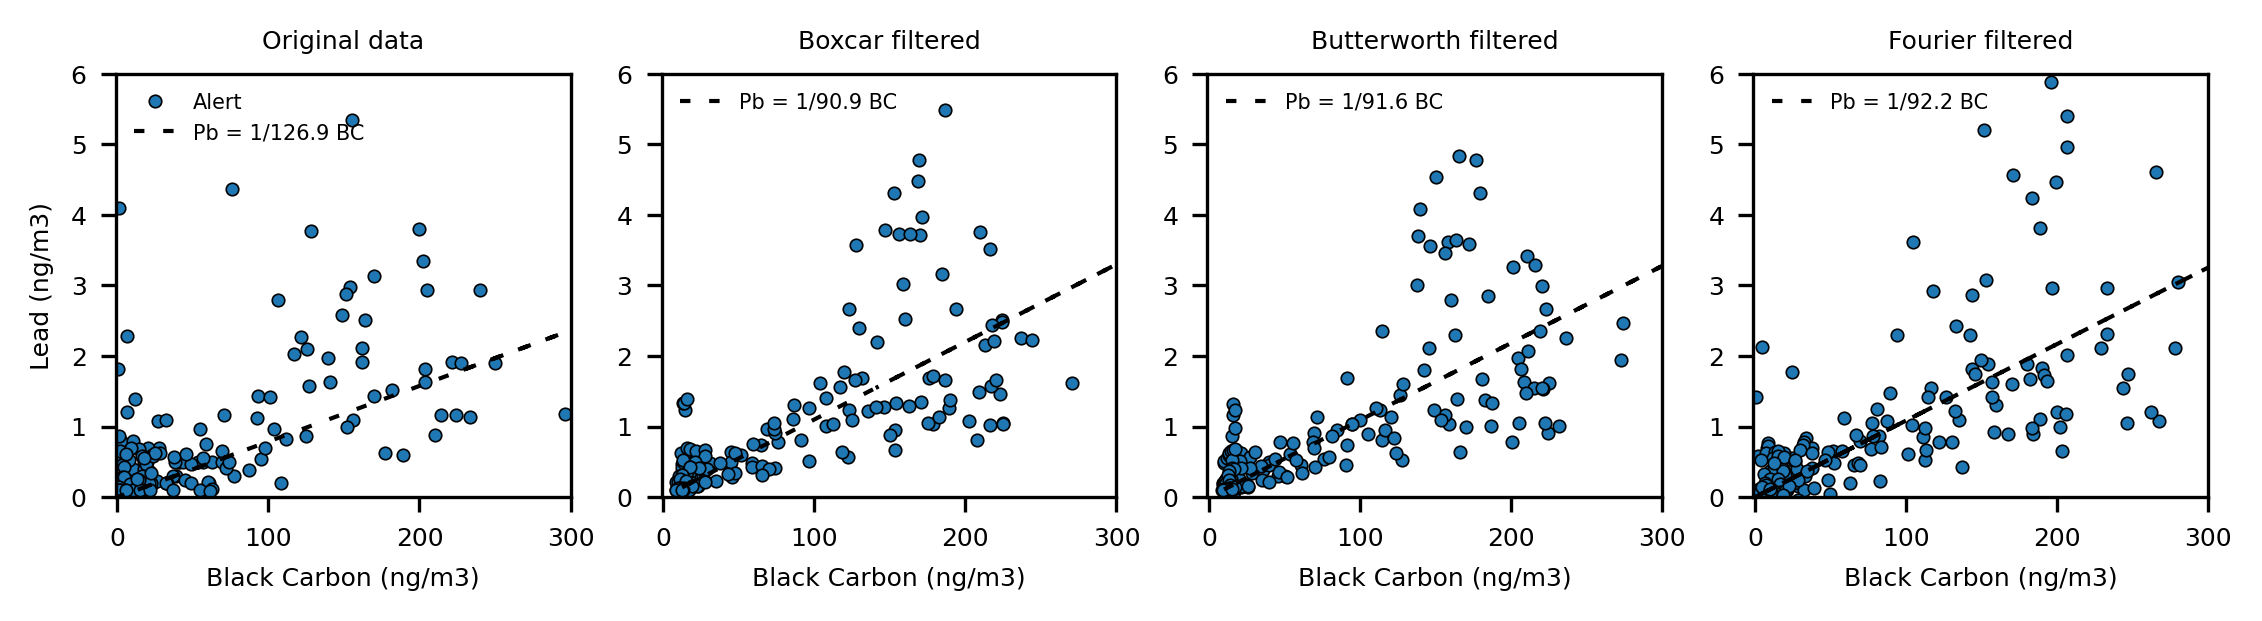

In [69]:
fig, ax = plt.subplots(1,4, figsize=(4.5*2, 3.74*0.5), dpi=300)
# plt.rcParams['text.usetex'] = True

ax[0].plot(Alert_EBC_match, Alert_Pb_match, '.',  markersize=6, markeredgecolor='k', markeredgewidth=0.4, label='Alert')
ax[0].plot(Alert_EBC_match, f_start_Alert, '--k', linewidth=1.0, label=f'Pb = 1/{1/p1_start_Alert[0]:.1f} BC', dashes=(2.5,4.5))
ax[0].set_ylabel('Lead (ng/m3)', fontsize=6)
ax[0].set_title('Original data', fontsize=6)
ax[0].tick_params(axis='both', labelsize=6)
    
ax[1].plot(Alert_EBC_boxcar_match, Alert_Pb_boxcar_match, '.',  markersize=6, markeredgecolor='k', markeredgewidth=0.4)
ax[1].plot(Alert_EBC_boxcar_match, f_boxcar_Alert, '--k', linewidth=1.0, label=f'Pb = 1/{1/p1_boxcar_Alert[0]:.1f} BC', dashes=(2.5,4.5))
ax[1].set_title('Boxcar filtered', fontsize=6)
ax[1].tick_params(axis='both', labelsize=6)

ax[2].plot(Alert_EBC_butter_match, Alert_Pb_butter_match, '.',  markersize=6, markeredgecolor='k', markeredgewidth=0.4)
ax[2].plot(Alert_EBC_butter_match, f_butter_Alert, '--k', linewidth=1.0, label=f'Pb = 1/{1/p1_butter_Alert[0]:.1f} BC', dashes=(2.5,4.5))
ax[2].set_title('Butterworth filtered', fontsize=6)
ax[2].tick_params(axis='both', labelsize=6)

ax[3].plot(Alert_EBC_fourier_match, Alert_Pb_fourier_match, '.',  markersize=6, markeredgecolor='k', markeredgewidth=0.4)
ax[3].plot(Alert_EBC_fourier_match, f_fourier_Alert, '--k', linewidth=1.0, label=f'Pb = 1/{1/p1_fourier_Alert[0]:.1f} BC', dashes=(2.5,4.5))
ax[3].set_title('Fourier filtered', fontsize=6)
ax[3].tick_params(axis='both', labelsize=6)

for axis in ax.ravel():
    axis.set_xlim([-1, 300])
    axis.set_ylim([-0, 6])
    axis.set_xlabel('Black Carbon (ng/m3)', fontsize=6)
    axis.legend(fontsize=5, loc=2, frameon=False)

Text(0.5, 1.0, 'Alert Research Station data')

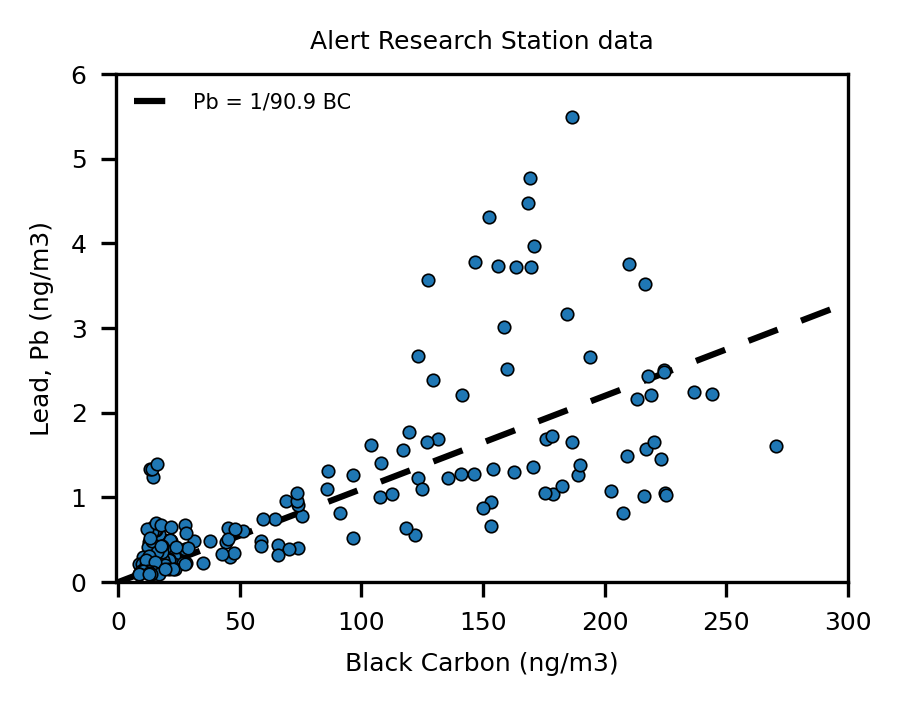

In [79]:
fig, ax = plt.subplots(1,1, figsize=(4.5*0.7, 3.74*0.6), dpi=300)

BC_array = np.linspace(0,300,50)    
ax.plot(BC_array, p1_boxcar_Alert*BC_array, '--k', linewidth=1.5, label=f'Pb = 1/{1/p1_boxcar_Alert[0]:.1f} BC', dashes=(5,4))
ax.plot(Alert_EBC_boxcar_match, Alert_Pb_boxcar_match, '.', markersize=6, markeredgecolor='k', markeredgewidth=0.4)
ax.tick_params(axis='both', labelsize=6)

ax.set_xlim([-1, 300])
ax.set_ylim([-0, 6.0])
ax.set_xlabel('Black Carbon (ng/m3)', fontsize=6)
ax.set_ylabel('Lead, Pb (ng/m3)', fontsize=6)
ax.legend(fontsize=5, loc=2, frameon=False)

ax.set_title('Alert Research Station data', fontsize=6)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Villum_Pb_BC_ratio.png')

In [83]:
print('Correlation before any filtering is applied:')
print(f'Pearson r: {pearsonr(Alert_EBC_match, Alert_Pb_match)[0]:.2f}')
print(f'Spearman r: {spearmanr(Alert_EBC_match, Alert_Pb_match)[0]:.2f}') # rank correlation

print('Correlation after boxcar filtering:')
print(f'Pearson r: {pearsonr(Alert_EBC_boxcar_match, Alert_Pb_boxcar_match)[0]:.2f}')
print(f'Spearman r: {spearmanr(Alert_EBC_boxcar_match, Alert_Pb_boxcar_match)[0]:.2f}') # rank correlation

print('Correlation after Butterworth filtering:')
print(f'Pearson r: {pearsonr(Alert_EBC_butter_match, Alert_Pb_butter_match)[0]:.2f}')
print(f'Spearman r: {spearmanr(Alert_EBC_butter_match, Alert_Pb_butter_match)[0]:.2f}') # rank correlation

print('Correlation after Fourier filtering:')
print(f'Pearson r: {pearsonr(Alert_EBC_fourier_match, Alert_Pb_fourier_match)[0]:.2f}')
print(f'Spearman r: {spearmanr(Alert_EBC_fourier_match, Alert_Pb_fourier_match)[0]:.2f}') # rank correlation

Correlation before any filtering is applied:
Pearson r: 0.54
Spearman r: 0.65
Correlation after boxcar filtering:
Pearson r: 0.72
Spearman r: 0.80
Correlation after Butterworth filtering:
Pearson r: 0.72
Spearman r: 0.80
Correlation after Fourier filtering:
Pearson r: 0.70
Spearman r: 0.76
